In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

### Evaluation criterions

In [2]:
common_metrics = [
#     'Exploration Face loss',
#     'Exploration Edge loss',
#     'Exploration Chamfer loss',
#     'Exploration completeness',
#     'Map Face loss',
#     'Map Edge loss',
#     'Map Chamfer loss',
    'Artifacts Exploration completeness',
    'Detections score',
    'mAP',
#     'Total Expected reward',
#     'Total artifacts reward',
    'Travelled distance',
#     'Total Actual reward',
#     'Localization error: pos',
#     'Localization error: ang'
#     'Artifacts Localization error',
]

worlds = ["finals_qual"]

MIN_TRAVELLED_DIST = 100

paths = ['../data/bags/mapping_eval/dist_mask_only/']

# all metrics files
xls_files = [os.path.join(path, file) for path in paths for file in os.listdir(path) if 'xls' in file]
    
# filter by worlds
xls_files1 = []
for file in xls_files:
    for world in worlds:
        if world in file:
            xls_files1.append(file)
xls_files = xls_files1
    
# filter by computers
# computers = ['ritz', 'halmos', 'goedel']
# computers = ['halmos', 'ritz', 'zorn']
computers = ['halmos', 'ritz']
# computers = ['ritz']

xls_files1 = []
for file in xls_files:
    for comp in computers:
        if comp in file:
            xls_files1.append(file)
xls_files = xls_files1

In [3]:
# names = [
#     'Time stamp',
#     'Exploration Face loss',
#     'Exploration Edge loss',
#     'Exploration Chamfer loss',
#     'Exploration completeness',
#     'Map Face loss',
#     'Map Edge loss',
#     'Map Chamfer loss',
#     'Artifacts Exploration completeness',
#     'Detections score',
#     'mAP',
#     'Total Expected reward',
#     'Total artifacts reward',
#     'Travelled distance',
#     'Total Actual reward',
#     'Localization error: pos',
#     'Localization error: ang'
#     'Artifacts Localization error',
# ]

# from xlrd import open_workbook
# from xlutils.copy import copy

# for filepath in xls_files:
#     rb = open_workbook(filepath)
#     wb = copy(rb)
#     s = wb.get_sheet(0)
#     for i, name in enumerate(names):
#         s.write(0, i, name)
#     wb.save(filepath)

### All experiments

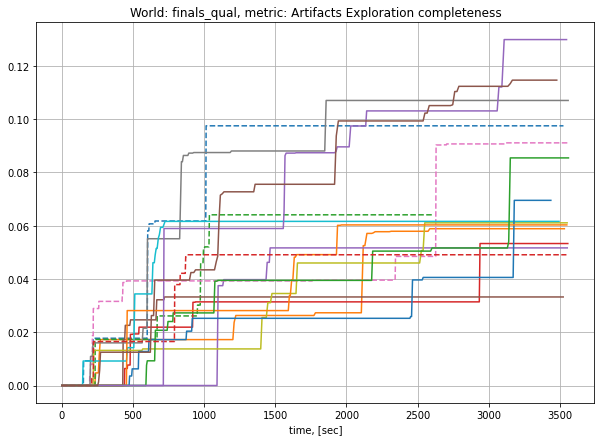

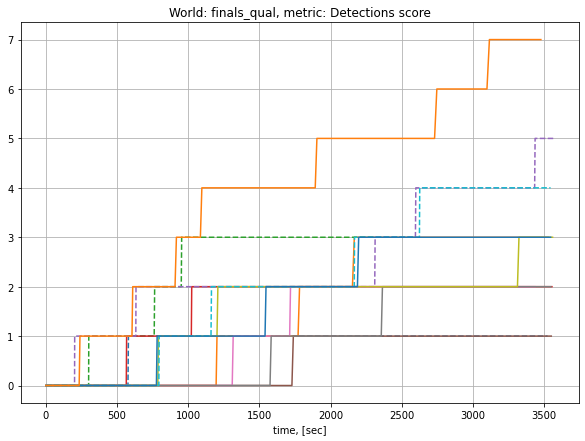

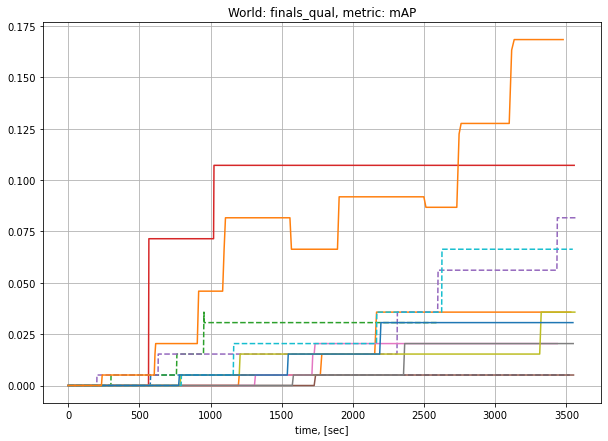

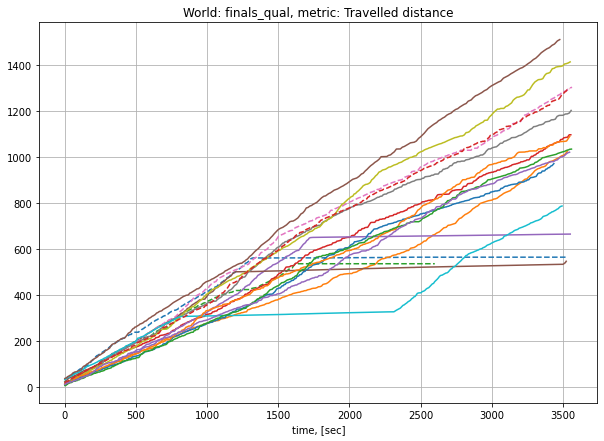

In [4]:
for world in worlds:
    for i, metric in enumerate(common_metrics):
        plt.figure(figsize=(10, 7))
        plt.title(f"World: {world}, metric: {metric}")
        xls_files_world = [file for file in xls_files if world in file]
        for file in xls_files_world:
            data = pd.read_excel(file)

            data = data.fillna(method='ffill')
            
            if np.max(data[metric]) > 0 and np.max(data['Localization error: pos']) < 5.0: # might be corrupted data with wrong tfs
                ls = 'solid' if not 'enable_fov_vis_false' in file else 'dashed'
                t = data['Time stamp'] - data['Time stamp'][0]
                plt.plot(t, data[metric], linestyle=ls, label=file)
                                
        plt.grid()
        plt.xlabel('time, [sec]')
        # plt.legend()
        plt.show()
        plt.close()

In [5]:
for key in data:
    print(key)

Time stamp
Exploration Face loss
Exploration Edge loss
Exploration Chamfer loss
Exploration completeness
Map Face loss
Map Edge loss
Map Chamfer loss
Artifacts Exploration completeness
Detections score
mAP
Total Expected reward
Total artifacts reward
Travelled distance
Total Actual reward
Localization error: pos
Localization error: ang
Detected artifacts
Artifacts Localization error


In [6]:
data.head()

,Time stamp,Exploration Face loss,Exploration Edge loss,Exploration Chamfer loss,Exploration completeness,Map Face loss,Map Edge loss,Map Chamfer loss,Artifacts Exploration completeness,Detections score,mAP,Total Expected reward,Total artifacts reward,Travelled distance,Total Actual reward,Localization error: pos,Localization error: ang,Detected artifacts,Artifacts Localization error
0,92.875391,-1,NaN,NaN,0,-1,NaN,NaN,0.0,0.0,0.0,0,0.0,36.120788,7952.846680,0.034308,0.005572,[],NaN
1,94.183260,-1,NaN,NaN,0,-1,NaN,NaN,0.0,0.0,0.0,0,0.0,36.144876,7952.846680,0.033910,0.005077,[],NaN
2,95.590041,-1,NaN,NaN,0,-1,NaN,NaN,0.0,0.0,0.0,0,0.0,36.628153,8028.010254,0.033438,0.004416,[],NaN
3,96.796791,-1,NaN,NaN,0,-1,NaN,NaN,0.0,0.0,0.0,0,0.0,37.039609,8110.556152,0.033398,0.004236,[],NaN
4,98.034026,-1,NaN,NaN,0,-1,NaN,NaN,0.0,0.0,0.0,0,0.0,37.047821,8146.776367,0.038697,0.004295,[],NaN


### Average results

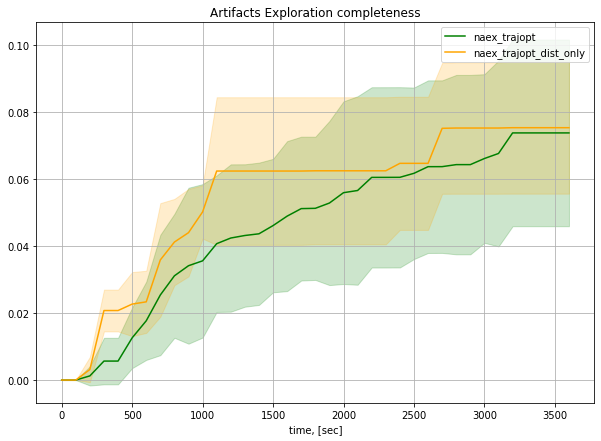

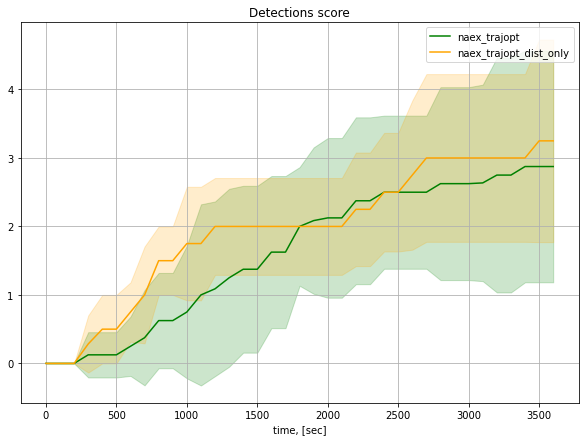

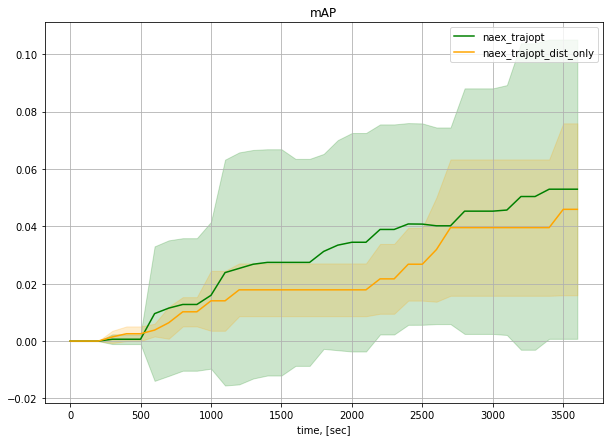

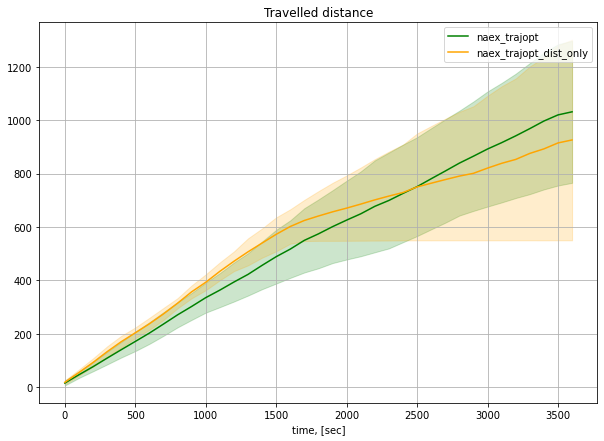

In [7]:
xls_files_useful = []

for metric in common_metrics:
    ts, values = [], []
    ts_dist_only, values_dist_only = [], []
    for file in xls_files:
        data = pd.read_excel(file)
        data = data.fillna(method='ffill')

        if metric in data and \
           np.max(data['Localization error: pos']) < 5.0 and \
           np.max(data['Travelled distance']) > MIN_TRAVELLED_DIST and \
           np.max(data[metric]) > 0:
                  
            t = np.array(data["Time stamp"] - data["Time stamp"][0])
            value = np.array(data[metric])

            if 'enable_fov_vis_false' in file:
                ts_dist_only.append(t)
                values_dist_only.append(value)
            else:
                ts.append(t)
                values.append(value)

            xls_files_useful.append(file)

    if len(xls_files_useful) == 0:
        print('No data')
        break

    t_mean = np.linspace(0, 3600, 37)

    values_interp = [np.interp(t_mean, t, v) for t, v in zip(ts, values)]
    mean = np.mean(values_interp, axis=0) 
    std = np.std(values_interp, axis=0)
    
    values_interp = [np.interp(t_mean, t, v) for t, v in zip(ts_dist_only, values_dist_only)]
    mean_dist_only = np.mean(values_interp, axis=0) 
    std_dist_only = np.std(values_interp, axis=0)

    plt.figure(figsize=(10, 7))
    plt.title(metric)
    # for t, v, v_interp in zip(ts, values, values_interp):
    #     plt.plot(t, v)
    #     plt.plot(t_mean, v_interp, 'x')

    plt.plot(t_mean, mean, label='naex_trajopt', color='green')
    plt.fill_between(t_mean, mean-std, mean+std, color='green', alpha=0.2)
    
    plt.plot(t_mean, mean_dist_only, label='naex_trajopt_dist_only', color='orange')
    plt.fill_between(t_mean, mean_dist_only-std_dist_only, mean_dist_only+std_dist_only, color='orange', alpha=0.2)
    
    plt.grid()
    plt.xlabel('time, [sec]')
    plt.legend()

    plt.show()
    plt.close()

In [8]:
xls_files_useful = set(xls_files_useful)  # remove dublicates

for world_name in worlds:
    n_naex = len([file for file in xls_files_useful if world_name in file and not "enable_fov_vis_false" in file])
    n_naex_dist_only = len([file for file in xls_files_useful if world_name in file and "enable_fov_vis_false" in file])

    print(world_name, "N naex:", n_naex, "N naex dist mask only:", n_naex_dist_only)

finals_qual N naex: 12 N naex dist mask only: 4


In [9]:
for cmp_name in computers:
    n_naex = len([file for file in xls_files_useful if cmp_name in file and not "enable_fov_vis_false" in file])
    n_naex_dist_only = len([file for file in xls_files_useful if cmp_name in file and "enable_fov_vis_false" in file])

    print(cmp_name, "N naex:", n_naex, "N naex dist mask only:", n_naex_dist_only)

halmos N naex: 5 N naex dist mask only: 1
ritz N naex: 7 N naex dist mask only: 3
